In [ ]:
from tensorflow import keras

# Classification des critiques de films: un exemple de classification binaire

La classification à deux classes, ou classification binaire, peut être le type de problème d’apprentissage automatique le plus largement appliqué. Dans cet exemple, nous apprendra à classer les critiques de films en critiques "positives" et "négatives", uniquement en fonction du contenu textuel des critiques.

## The IMDB dataset

Nous allons travailler avec "l'ensemble de données IMDB", un ensemble de 50 000 critiques de la base de données Internet Movie. Ils sont divisés en 25 000 revues pour l'apprentissage et 25 000 revues pour les tests, chaque série comprenant 50% de critiques négatives et 50% de critiques positives.

Tout comme le jeu de données MNIST, le jeu de données IMDB est fourni avec Keras.

Il a déjà été prétraité: les critiques (séquences de mots) ont été transformés en séquences d’entiers, chaque entier représentant un mot spécifique dans un dictionnaire.

Le code suivant chargera le jeu de données (lorsque vous l'exécuterez pour la première fois, environ 80 Mo de données seront téléchargés sur votre ordinateur):

In [ ]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



- `num_words = 10000` signifie que nous ne conserverons que les 10 000 mots les plus fréquents dans les données d'apprentissage. Cela nous permet de travailler avec des données vectorielles de taille gérable.

- `train_data` et` test_data` sont des listes de revues, chaque revue étant une liste d'index de mots (codant une séquence de mots).
- `train_labels` et` test_labels` sont des listes de 0 et de 1, où 0 signifie "négatif" et 1, "positif"

Voici comment décoder une revue :

In [ ]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [ ]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Préparation des données


Nous ne pouvons pas introduire de listes d'entiers dans un réseau de neurones. Nous devons transformer nos listes en tenseurs. Nous pouvons le faire de deux manières :

- Nous pourrions compiler nos listes pour qu’elles aient toutes la même longueur et les transformer en un tenseur entier de forme `(samples, word_indices)`, puis utiliser comme première couche de notre réseau une couche capable de gérer de tels tenseurs entiers (la couche `Embedding`).

- Nous pourrions coder à chaud nos listes pour les transformer en vecteurs de 0 et de 1. Concrètement, cela signifierait, par exemple, tourner la séquence `[3, 5]` dans un vecteur de 10 000 dimensions qui serait composé de zéros sauf les indices 3 et 5, qui seraient un. Ensuite, nous pourrions utiliser comme première couche de notre réseau, une couche `Dense`, capable de traiter des données vectorielles à virgule flottante.

Nous utilisons cette dernière solution. Vectorisons nos données, ce que nous ferons manuellement pour une clarté maximale:

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

On vectorise aussi nos labels :

In [ ]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
x_train.shape

(25000, 10000)

In [ ]:
x_train[0].sum()

np.float64(120.0)


## Construire notre réseau

Nos données d'entrée sont simplement des vecteurs et nos étiquettes sont des scalaires (1 et 0): c'est la configuration la plus simple.

Un réseau qui fonctionne bien sur un tel problème serait une simple pile de couches entièrement connectées (`Dense`) avec les activations `relu`: `Dense (16,activation = 'relu')`

L'argument transmis à chaque couche `Dense` (16) est le nombre d'unités cachées de la couche.

**Exercice :** Implémentez ce réseau avec tensorflow et keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers

input_dim = x_train.shape[1]
hidden_dim = 16
output_dim = 1

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="relu"))
model.add(Dense(output_dim, activation="sigmoid"))

#model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
#              loss='binary_crossentropy', metrics=['accuracy'])

#history = model.fit(x_train, y_train, validation_split=0.2, epochs=15, batch_size=32)

Enfin, nous devons choisir une fonction de perte et un optimiseur.

Puisque nous sommes confrontés à un problème de classification binaire et à la sortie de notre réseau est une probabilité, il est préférable d'utiliser la perte `binary_crossentropy`.

Ce n'est pas le seul choix viable: vous pouvez utiliser, par exemple, `mean_squared_error`. Mais la cross-centropie est généralement le meilleur choix lorsque vous traitent des modèles qui produisent des probabilités.

Voici l'étape où nous configurons notre modèle avec l'optimiseur `rmsprop` et la fonction de perte` binary_crossentropy`. Notez que nous allons surveillez également la précision pendant l'apprentissage.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', #category_crossentropy pour les mullticlass
              metrics=['accuracy'])


## Valider notre approche

Afin de contrôler au cours de l'apprentissage la précision du modèle sur des données qu’il n’a jamais vues auparavant, nous allons créer un "jeu de validation" avec 10 000 échantillons des données d'entraînement originales :

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]


Nous allons maintenant apprendre notre modèle pour 20 époques (20 itérations sur tous les échantillons des tenseurs `x_train` et` y_train`), en mini-lots de 512 échantillons.

Parallèlement, nous surveillerons la perte et la précision des 10 000 échantillons que nous avons mis de côté. Ceci est fait en passant les données de validation en tant qu'argument `validation_data`:

**Exercice :** Lancer l'apprentissage du modèle

In [ ]:
history = model.fit(partial_x_train, partial_y_train, validation_data=(x_val, y_val), epochs=20, batch_size=512)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6869 - loss: 0.5851 - val_accuracy: 0.8590 - val_loss: 0.4028
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8955 - loss: 0.3443 - val_accuracy: 0.8809 - val_loss: 0.3240
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9187 - loss: 0.2640 - val_accuracy: 0.8870 - val_loss: 0.2958
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9327 - loss: 0.2222 - val_accuracy: 0.8873 - val_loss: 0.2812
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9420 - loss: 0.1857 - val_accuracy: 0.8870 - val_loss: 0.2831
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9511 - loss: 0.1685 - val_accuracy: 0.8870 - val_loss: 0.2764
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9523 - loss: 0.1552 - val_accuracy: 0.8869 - val_loss: 0.2775
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9611 - loss: 0.1361 - val_accuracy: 0.8841 - v

On peut afficher quelques graphiques :

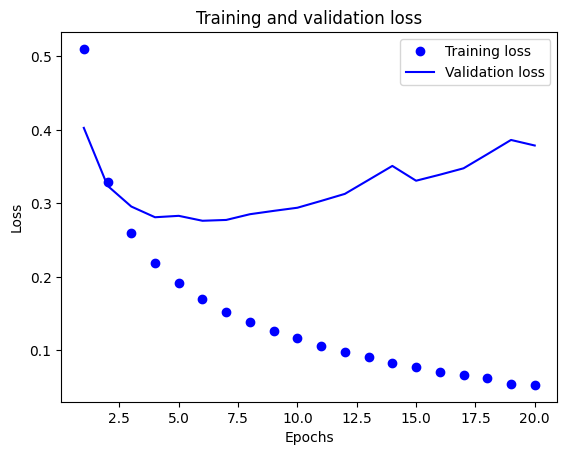

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

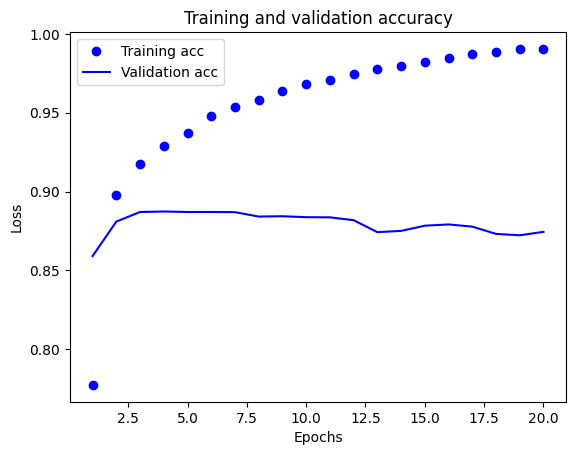

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Les points représentent la perte et la précision de l'apprentissage, tandis que les traits pleins représentent la perte et la précision de la validation.

Pour combler ce problème, on pourrait réduire le nombre d'époques.

**Exercice** : Essayez de reconstruire un réseau avec 4 époques.

In [ ]:
# performance est satisfaite, on réapprends tout le modèle en entier avec les hyperparamètres optimaux

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="relu"))
model.add(Dense(output_dim, activation="sigmoid"))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', #category_crossentropy pour les mullticlass
              metrics=['accuracy'])

history= model.fit(partial_x_train, partial_y_train, validation_data=(x_val, y_val), epochs=4, batch_size=512)

model.save("model.h5")

Epoch 1/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7039 - loss: 0.5899 - val_accuracy: 0.8647 - val_loss: 0.4123
Epoch 2/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8927 - loss: 0.3603 - val_accuracy: 0.8777 - val_loss: 0.3380
Epoch 3/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9141 - loss: 0.2788 - val_accuracy: 0.8828 - val_loss: 0.3035
Epoch 4/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9265 - loss: 0.2330 - val_accuracy: 0.8890 - val_loss: 0.2875



## Utiliser un réseau pour générer des prévisions sur de nouvelles données

Après avoir formé un réseau, vous souhaiterez l’utiliser de manière pratique. Vous pouvez générer la probabilité que les avis soient positifs en utilisant la méthode `Predict`:

In [ ]:
y_pred = (model.predict(x_test) > 0.5 ).astype('float')[:,0]
y_pred

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([0., 1., 1., ..., 0., 0., 1.])

Accuracy: 0.88336
Precision: 0.8634708737864077
Recall: 0.91072
F1 score: 0.8864662825105124


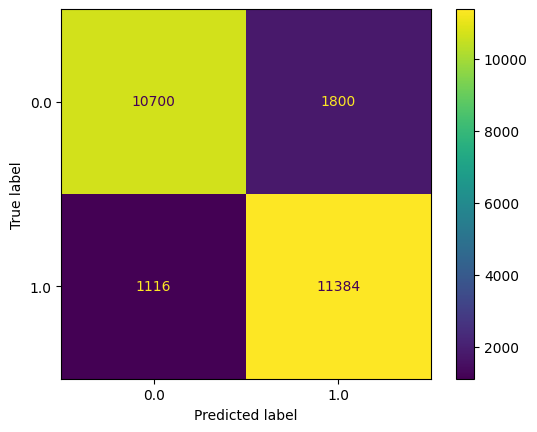

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 score:", f1)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


## Autres expériences


* Nous utilisions 2 couches cachées. Essayez d'utiliser 1 ou 3 couches cachées et voyez comment cela affecte la validation et la précision des tests.
* Essayez d'utiliser des couches avec plus d'unités cachées ou moins: 32 unités, 64 unités ...
* Essayez d’utiliser la fonction de perte `mse` au lieu de` binary_crossentropy`.
* Essayez d'utiliser l'activation `tanh` (une activation qui était populaire dans les premiers jours des réseaux de neurones) au lieu de` relu`.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import optimizers

input_dim = x_train.shape[1]
hidden_dim = 16
output_dim = 1

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(output_dim, activation="sigmoid"))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history= model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=512)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7163 - loss: 0.5853 - val_accuracy: 0.8710 - val_loss: 0.4071
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8684 - loss: 0.3834 - val_accuracy: 0.8766 - val_loss: 0.3372
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8944 - loss: 0.3029 - val_accuracy: 0.8860 - val_loss: 0.2964
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9119 - loss: 0.2594 - val_accuracy: 0.8924 - val_loss: 0.2797
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9204 - loss: 0.2282 - val_accuracy: 0.8938 - val_loss: 0.2715
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9295 - loss: 0.2031 - val_accuracy: 0.8918 - val_loss: 0.2709
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9353 - loss: 0.1888 - val_accuracy: 0.8952 - val_loss: 0.2679
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9384 - loss: 0.1704 - val_accuracy: 0.8938 - v

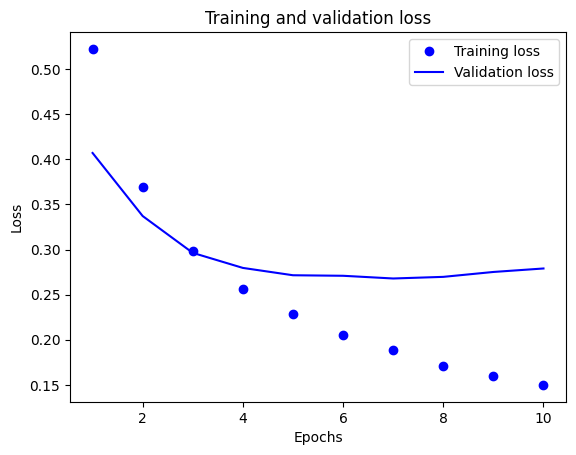

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import optimizers

input_dim = x_train.shape[1]
hidden_dim = 32
output_dim = 1

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(output_dim, activation="sigmoid"))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history= model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=512)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7289 - loss: 0.5599 - val_accuracy: 0.8780 - val_loss: 0.3573
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8798 - loss: 0.3322 - val_accuracy: 0.8784 - val_loss: 0.3195
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9079 - loss: 0.2629 - val_accuracy: 0.8916 - val_loss: 0.2799
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9199 - loss: 0.2232 - val_accuracy: 0.8674 - val_loss: 0.3205
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9305 - loss: 0.1991 - val_accuracy: 0.8818 - val_loss: 0.2927
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9353 - loss: 0.1809 - val_accuracy: 0.8880 - val_loss: 0.2789
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9443 - loss: 0.1623 - val_accuracy: 0.8878 - val_loss: 0.2792
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9510 - loss: 0.1430 - val_accuracy: 0.8878 - v

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import optimizers

input_dim = x_train.shape[1]
hidden_dim = 32
output_dim = 1

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(output_dim, activation="sigmoid"))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history= model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=512)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6699 - loss: 0.6040 - val_accuracy: 0.8638 - val_loss: 0.3865
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8631 - loss: 0.3731 - val_accuracy: 0.8906 - val_loss: 0.2930
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9021 - loss: 0.2727 - val_accuracy: 0.8742 - val_loss: 0.3119
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9233 - loss: 0.2179 - val_accuracy: 0.8888 - val_loss: 0.2792
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9370 - loss: 0.1818 - val_accuracy: 0.8904 - val_loss: 0.2901
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9479 - loss: 0.1500 - val_accuracy: 0.8886 - val_loss: 0.3037
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9608 - loss: 0.1278 - val_accuracy: 0.8890 - val_loss: 0.3213
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9672 - loss: 0.1056 - val_accuracy: 0.8866 - v

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import optimizers

input_dim = x_train.shape[1]
hidden_dim = 64
output_dim = 1

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="relu"))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation="sigmoid"))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history= model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=512)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6989 - loss: 0.5718 - val_accuracy: 0.8184 - val_loss: 0.4116
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8935 - loss: 0.2882 - val_accuracy: 0.8454 - val_loss: 0.3663
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9141 - loss: 0.2219 - val_accuracy: 0.8898 - val_loss: 0.2813
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9405 - loss: 0.1709 - val_accuracy: 0.8898 - val_loss: 0.2817
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9503 - loss: 0.1409 - val_accuracy: 0.8770 - val_loss: 0.3435
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9521 - loss: 0.1284 - val_accuracy: 0.8656 - val_loss: 0.4037
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9611 - loss: 0.1069 - val_accuracy: 0.8852 - val_loss: 0.3338
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9707 - loss: 0.0843 - val_accuracy: 0.8806 - v